# Shakespeare Recommender System

William Shakespeare is considered one of the greatest playwrights in the English language. He is attributed with 38 plays, 154 sonnets, and other works. Even 400 years later, his writings are still be studied in most high schools and colleges in the US and elsewhere. Shakespeare’s complete works are available online at http://shakespeare.mit.edu/.  I will be using a data set which has Shakespeare character quotes.  A lot of people are fascinated by the characters in the Shakespeare plays.  The first first part of the project is to create a Shakespeare character recommender system which is capable of recommending new characters which are similar to a speicific character of interest.  Then I will also explore using PCA inference to find important words in character quotes. In the second part of the project I will use K-Means clustering to try and find one or more character insights. 

In [ ]:
%%bash
# Do not change or modify this file
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark

# Download the data files from github
# If the data file does not exist in the colab environment
if [[ ! -f ./quotes_by_char.csv ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/wewilli1/ist718_data/master/quotes_by_char.csv  
fi

  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=c23a9c54f4c55ae7948228ce3c56268fea21d8bb86b3792c511e54846a994203
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


--2020-11-08 23:04:58--  https://raw.githubusercontent.com/wewilli1/ist718_data/master/quotes_by_char.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4352265 (4.2M) [text/plain]
Saving to: ‘quotes_by_char.csv’

     0K .......... .......... .......... .......... ..........  1% 2.25M 2s
    50K .......... .......... .......... .......... ..........  2% 4.93M 1s
   100K .......... .......... .......... .......... ..........  3% 13.9M 1s
   150K .......... .......... .......... .......... ..........  4% 20.6M 1s
   200K .......... .......... .......... .......... ..........  5% 8.66M 1s
   250K .......... .......... .......... .......... ..........  7% 27.9M 1s
   300K .......... .......... .......... .......... ..........  8% 25.2M 1s
   350K .......... .......

# Part 1: Recommender System

# Import dataset
Read the quotes_by_char.csv file into a spark dataframe named `quotes_by_char_df`.  Drop the `Unnamed` column.  Transform the character column such that all character names are lower case.

In [ ]:
# import statements
from pyspark.sql.functions import col, lower
from pyspark.sql import SparkSession, SQLContext

spark = SparkSession\
  .builder\
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "12g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","12g")\
  .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [ ]:
quotes_by_char_df = spark.read.format("csv").option("header", "true").load("quotes_by_char.csv")
quotes_by_char_df.show(5)

+---+-----------+--------------------+
|_c0|  character|          all_quotes|
+---+-----------+--------------------+
|  0|        & C|Well met, Master ...|
|  1|     A Lord|     Sir, it was I. |
|  2|A Patrician|This man has marr...|
|  3|   A Player|So please your lo...|
|  4|      AARON|Now climbeth Tamo...|
+---+-----------+--------------------+
only showing top 5 rows



In [ ]:
quotes_by_char_df = quotes_by_char_df.select('character', 'all_quotes')
quotes_by_char_df = quotes_by_char_df.withColumn('character', lower(col('character')))
quotes_by_char_df.show(5)

+-----------+--------------------+
|  character|          all_quotes|
+-----------+--------------------+
|        & c|Well met, Master ...|
|     a lord|     Sir, it was I. |
|a patrician|This man has marr...|
|   a player|So please your lo...|
|      aaron|Now climbeth Tamo...|
+-----------+--------------------+
only showing top 5 rows



# Principal Component Analysis (PCA) Pipeline
Create a spark pipeline named `pipe_pca_1` which performs Principal Component Analysis (PCA) on `chars_df`.  Use `pipe_pca_1` to create a new dataframe named `chars_pca_df`.  Analyze the resulting number of TF-IDF data rows and columns in the data. Using the analysis for the number of rows and cols in the data, explicitly set the K parameter in the spark PCA object equal to the maximum number of principal components.

In [ ]:
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import IDF
import requests
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import PCA
from pyspark.ml import feature

stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()

tokenizer = feature.RegexTokenizer(minTokenLength=2).setGaps(False).setPattern("\\p{L}+").setInputCol("all_quotes").setOutputCol("words")
sw_filter = feature.StopWordsRemover().setStopWords(stop_words).setCaseSensitive(False).setInputCol("words").setOutputCol("filtered")
cv = feature.CountVectorizer(minTF=1., minDF=5.).setInputCol("filtered").setOutputCol("tf")
idf = feature.IDF().setInputCol('tf').setOutputCol('tfidf')
#center = feature.StandardScaler(withMean=True, withStd=False, inputCol='tfidf', outputCol='centered_tfidf')
pca = PCA(k=500, inputCol='tfidf', outputCol='pcafeatures')


pipe_pca_1 = Pipeline(stages=[tokenizer, sw_filter, cv, idf, pca]).fit(quotes_by_char_df)

In [ ]:
chars_pca_df = pipe_pca_1.transform(quotes_by_char_df)

In [ ]:
chars_pca_df.show(5)

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  character|          all_quotes|               words|            filtered|                  tf|               tfidf|         pcafeatures|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        & c|Well met, Master ...|[well, met, maste...| [met, master, ford]|(7408,[36,446,791...|(7408,[36,446,791...|[-0.3667651354519...|
|     a lord|     Sir, it was I. |      [sir, it, was]|               [sir]|    (7408,[6],[1.0])|(7408,[6],[0.7738...|[-0.0569866019953...|
|a patrician|This man has marr...|[this, man, has, ...|[man, marr, fortu...|(7408,[11,42,120,...|(7408,[11,42,120,...|[-0.2102382538728...|
|   a player|So please your lo...|[so, please, your...|[lordship, accept...|(7408,[5,22,46,48...|(7408,[5,22,46,48...|[-0.5313523092718...|
|      aaron|Now cli

In [ ]:
# print the number of rows and cols in the TF-IDF data in chars_pca_df here
num_row = chars_pca_df.count()
num_word = chars_pca_df.select('tfidf').collect()[0][0].size
print('The number of rows:', num_row, '\nThe number of cols:', num_word)

The number of rows: 966 
The number of cols: 7408


# scree and cumulative variance explained plots


In [ ]:
sum(pipe_pca_1.stages[-1].explainedVariance)

0.9835747440755382

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

# scree polot
explained_var = pipe_pca_1.stages[-1].explainedVariance
fig = px.line(x=np.arange(1, len(explained_var)+1), y=explained_var, template='plotly_dark')
fig.update_layout(width=1000, 
                  height=500, 
                  xaxis_title="Principal Component",
                  yaxis_title="Proportion Variance Explained",
                  title={
                      'text': 'Shakespeare quotes Dataset Scree Plot',
                      'y':0.95,
                      'x':0.5,
                      'xanchor': 'center',
                      'yanchor': 'top'})
fig.show()

In [ ]:
# explained variance - plot the cumulative variance vs. the principal components
cum_sum = np.cumsum(explained_var)
fig = px.line(x=np.arange(1, len(explained_var)+1), y=cum_sum, template='plotly_dark')
fig.update_layout(width=1000, 
                  height=500, 
                  xaxis_title="Cumulative Components",
                  yaxis_title="Cumulative Sum of Variance Explained",
                  title={
                      'text': 'Shakespeare quotes Dataset Cumulative Sum of Variance Explained',
                      'y':0.95,
                      'x':0.5,
                      'xanchor': 'center',
                      'yanchor': 'top'})
fig.show()

I'm trying to reduce the number of columns to train a machine learning model, how many princiapal components should pick such that the number of data columns is reduced from the original data set but I can still capture a reasonable amount of variance in the data. 

From the cumulative sum of variance explained plot, we can see the first 16 principal components explains 40% of the variance of the data set. The first 50 principal components explain 60%, the first 150 explain 81%, and so on. This shows that we need just 140 of the 500 principal components to explain over 80% of the variance in the original data. We can reduce the number of variables from 500 to 140 whilst still retaining over 80% of the 'information' contained within the original data.

# Recommendation System
Create a function named get_nearest_chars that takes 2 arguments: char and num_nearest_chars. The char arg is a string which defines the character for which we are interested in finding similar characters. The num_nearest_chars arg is an integer that defines the total number of nearest characters which we want included in the return list. The get_nearest_chars function shall perform all of its internal operations in spark and return a python list containing a string corresponding to each of the nearest characters defined by num_nearest_chars. Compute the list of characterss which are closest to the char arg using L2 Euclidian distance. 

The get_nearest_chars function will also rigorously error check input data to verify that the user is not making illegal requests.

In [ ]:
from pyspark.ml import clustering

center = feature.StandardScaler(withMean=True, withStd=False, inputCol='tfidf', outputCol='centered_tfidf')
norm = feature.Normalizer(inputCol="centered_tfidf", outputCol="norm_tfidf", p=2.0)
kmeans = clustering.KMeans(k=6, featuresCol='norm_tfidf', predictionCol='kmeans_feat')
pca = feature.PCA(k=500, inputCol='centered_tfidf', outputCol='pcafeatures')
pipe_pca_2 = Pipeline(stages=[tokenizer, sw_filter, cv, idf, center, norm, kmeans, pca]).fit(quotes_by_char_df)

In [ ]:
  dfq4 = pipe_pca_2.transform(quotes_by_char_df)

In [ ]:
char_list = []
for i in range(dfq4.select('character').distinct().count()):
  char_list.append(dfq4.select("character").distinct().collect()[i][0])

In [ ]:
from pyspark.sql import functions as fn
from pyspark.sql import types

def l2_dist(c1, c2):    
    return float(np.sqrt((c1 - c2).T.dot((c1 - c2))))
l2_dist_udf = fn.udf(l2_dist, types.FloatType())


def get_nearest_chars(char, num_nearest_chars):
  """
  The char arg is a string which defines the character for which we are interested in finding similar characters. 
  The num_nearest_chars arg is an integer that defines the total number of nearest characters which we want included in the return list. 
  The get_nearest_chars function shall perform all of its internal operations in spark and 
  return a python list containing a string corresponding to each of the nearest characters defined by num_nearest_chars. 
  Compute the list of characterss which are closest to the char arg using L2 Euclidian distance.
  """
  k = dfq4[dfq4['character']==char].select('kmeans_feat').collect()[0][0]
  if char in char_list:
    df = dfq4.where(dfq4.character == char).\
        select(fn.col("pcafeatures").alias('new_scores')).\
        join(dfq4).\
        withColumn('dist', l2_dist_udf('pcafeatures', 'new_scores')).\
        select("character", "kmeans_feat", "dist").\
        orderBy(fn.asc("dist"))
    df = df.filter(df.kmeans_feat == k)
    if df.count() > num_nearest_chars:
      return df.show(num_nearest_chars+1)
    else:
      return print('There is not enough output. There are only',df.count(),'results.')
  else:
    return print('The input is wrong, no such character.')

In [ ]:
print(get_nearest_chars('romeo', 5))
print(get_nearest_chars('juliet', 5))

+--------------+-----------+---------+
|     character|kmeans_feat|     dist|
+--------------+-----------+---------+
|         romeo|          2|      0.0|
|friar laurence|          2|197.10457|
|  lady capulet|          2| 199.8148|
|      benvolio|          2|206.48375|
|         phebe|          2|209.69223|
|       capulet|          2|210.18468|
+--------------+-----------+---------+
only showing top 6 rows

None
+--------------+-----------+---------+
|     character|kmeans_feat|     dist|
+--------------+-----------+---------+
|        juliet|          2|      0.0|
|friar laurence|          2|201.91425|
|      benvolio|          2|212.80197|
|         nurse|          2| 213.2681|
|  lady capulet|          2|233.64963|
|      mercutio|          2|236.81972|
+--------------+-----------+---------+
only showing top 6 rows

None


In [ ]:
print(get_nearest_chars('a player', 500000))

There is not enough output. There are only 349 results.
None


# PCA Plot
Using PCA score data from PC1 and PC2, create a 2 dimensional character visualization plot which shows what characters are similar to the `juliet` character.  

In [ ]:
dfq5 = dfq4.where(dfq4.character == 'juliet').\
            select(fn.col("pcafeatures").alias('new_scores')).\
            join(dfq4).\
            withColumn('dist', l2_dist_udf('pcafeatures', 'new_scores')).\
            select("character", "kmeans_feat", "dist", "pcafeatures").\
            orderBy(fn.asc("dist"))
k = dfq5[dfq5['character']=='juliet'].select('kmeans_feat').collect()[0][0]
dfq5 = dfq5.filter(dfq5.kmeans_feat==k)

In [ ]:
dfq5.count()

290

In [ ]:
char_names = np.array(dfq5.select('character').rdd.map(lambda x: x['character']).collect())
X = np.array(dfq5.select('pcafeatures').rdd.map(lambda x: x['pcafeatures']).collect())
print("X.shape:", X.shape)

X.shape: (290, 500)


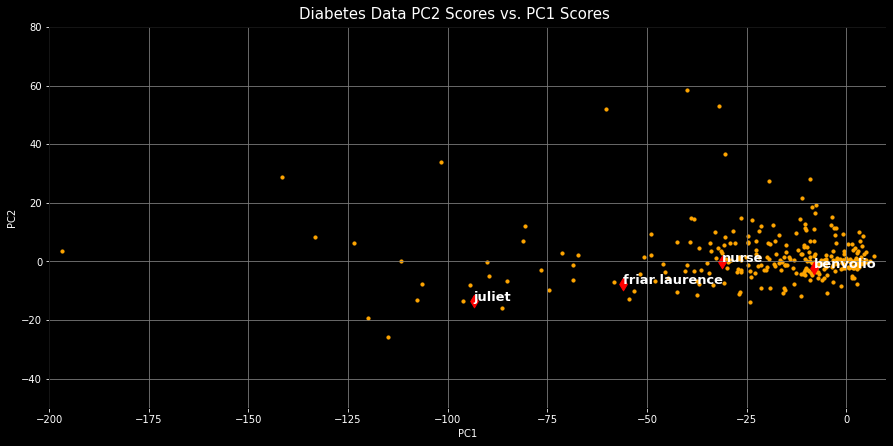

In [ ]:
# now plot the data
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(15)
for i in range(4,X.shape[0]):
  ax.scatter(X[i,0], X[i,1], marker='o', c='orange', s=10)
for i in range(4):
  ax.scatter(X[i,0], X[i,1], marker='d', c='red', s=80)
fig.suptitle("Diabetes Data PC2 Scores vs. PC1 Scores", y=.92, c='white', fontsize=15)
ax.set_xlim(-200,10)
ax.set_ylim(-50,80)
ax.set_xlabel("PC1", c='white')
ax.set_ylabel("PC2", c='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.grid(c='grey')
ax.set_facecolor('black')
fig.set_facecolor('black')

for i, txt in zip(range(4),char_names):
    ax.annotate(txt, (X[i,0], X[i,1]), fontsize=13, c='white', fontweight='bold')
    
plt.show()

# Feature Importance
Perform an inference analysis on the 10 most and 10 least important words in the data set as defined by the absolute value of the PC1 loading vector coefficients.  

In [ ]:
pca_model = pipe_pca_2.stages[-1]

In [ ]:
pc1 = pca_model.pc.toArray()[:, 0].tolist()
pc1 = [abs(i) for i in pc1]

In [ ]:
vocabulary = pipe_pca_2.stages[2].vocabulary

In [ ]:
import pandas as pd

pc_loadings = pd.DataFrame([vocabulary, pc1]).T.rename(columns={0: 'word',
                                                                1: 'load_pc1'})
print(pc_loadings.shape)

(7408, 2)


In [ ]:
least_imp_df = pc_loadings.sort_values('load_pc1').head(10)
most_imp_df = pc_loadings.sort_values('load_pc1').tail(10)

In [ ]:
# grading cell - do not modify
display(most_imp_df)
display(least_imp_df)

,word,load_pc1
9,let,0.0969137
7,come,0.0980477
4,good,0.0995506
8,ll,0.1066
2,shall,0.111358
18,king,0.111528
10,love,0.11519
3,thee,0.166313
1,thy,0.18303
0,thou,0.270044


,word,load_pc1
6009,carthage,1.31852e-08
7239,musters,1.62334e-06
6280,doubled,8.31181e-06
5309,leonine,1.57094e-05
7331,oats,1.62985e-05
5344,cauldron,2.2308e-05
6724,montagues,4.1953e-05
5770,epidamnum,7.83641e-05
7185,youths,8.36061e-05
6872,travelling,8.6912e-05


Loadings describe how much each variable contributes to a particular principal component. Large loadings (positive or negative) indicate that a particular variable has a strong relationship to a particular principal component. The sign of a loading indicates whether a variable and a principal component are positively or negatively correlated. Since in this question, we use the absolute value of pca loadings, so it's hard to see whether it's positively or negatively correelated. 

Form the dataframe we got above, words like let, come, goog, king, thou, etc. have strong relationship to the particular principal component. While words like carthage, travelling, oats have very small relationship with the principle component.

# Part 2: K-Means Clustering

# K-Means silhouette scores
Use the `chars_pca_df` from question 2 above and compute K-Means silhouette scores for K = 2 through 6 on the PCA score data. Train the model on each K 3 times to find the lowest silhouette score.  The silhouette score is a measure of within cluster variation.  Because K-Means starts out with random cluster assignments, it is not guaranteed to find a global minima so you should make multiple runs to find the lowest score.  Plot the silhouette scores vs. K and report the lowest silhouette score from the plot.

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

# change the column name tfidf to features for further exploration
dfq7 = chars_pca_df.withColumnRenamed('tfidf','features')

silhouette_list = []
k = []
# Trains a k-means model.
for i in range(2,7):
  kmeans = KMeans().setK(i).setSeed(3)
  model = kmeans.fit(dfq7)

  # Make predictions
  predictions = model.transform(dfq7)

  # Evaluate clustering by computing Silhouette score
  evaluator = ClusteringEvaluator()

  silhouette = round(evaluator.evaluate(predictions),4)
  print("Silhouette with squared euclidean distance = " + str(silhouette))
  silhouette_list.append(silhouette)
  k.append(i)

  # # Shows the result.
  # centers = model.clusterCenters()
  # print("Cluster Centers: ")
  # for center in centers:
  #     print(center)

Silhouette with squared euclidean distance = 0.9272
Silhouette with squared euclidean distance = 0.8086
Silhouette with squared euclidean distance = 0.8096
Silhouette with squared euclidean distance = 0.8407
Silhouette with squared euclidean distance = 0.7963


In [ ]:
import plotly.graph_objects as go
import plotly.express as px

fig = px.line(x=k, y=silhouette_list, template="plotly_dark", text=silhouette_list)
fig.update_traces(textposition='bottom center')
fig.update_layout(width=500, 
                  height=400, 
                  xaxis_title="k",
                  yaxis_title="silhouette score",
                  title={
                      'text': 'Silhouette Score Plot',
                      'y':0.9,
                      'x':0.5,
                      'xanchor': 'center',
                      'yanchor': 'top'})

fig.show()

In [ ]:
print("The highest silhouette score is whenk=2, it's 0.9272.")

The highest silhouette score is whenk=2, it's 0.9272.


# K-clusters Plot
Color the points by cluster assignment. I'm going to try to find an interesting insight about the Shakespeare characters.  For example, perhaps there is one or more outlier characters that stands apart from the rest of the characters in the cluster. 

In [ ]:
dfq8 = chars_pca_df.withColumnRenamed('tfidf','features')
kmeans = KMeans().setK(2)
model_8 = kmeans.fit(dfq8)

# Make predictions
predictions_8 = model_8.transform(dfq8)

In [ ]:
predictions_8.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   42|
|         0|  924|
+----------+-----+



In [ ]:
char_names = predictions_8.select('character').rdd.map(lambda x: x['character']).collect()
kmeans_feat = predictions_8.select('prediction').rdd.map(lambda x: x['prediction']).collect()
X = np.array(predictions_8.select('pcafeatures').rdd.map(lambda x: x['pcafeatures']).collect())
print("X.shape:", X.shape)

X.shape: (966, 500)


In [ ]:
from pyspark.sql import SQLContext

x_q8 = X[:,0].tolist()
y_q8 = X[:,1].tolist()
newdf = sqlContext.createDataFrame(zip(char_names, kmeans_feat, x_q8, y_q8),('character', 'kmeans', 'pc1','pc2'))

In [ ]:
newdf_pd = newdf.toPandas()
fig = px.scatter(newdf_pd, x='pc1', y='pc2', color='kmeans', template='plotly_dark',hover_data=["character"])
fig.update_layout(title={
                      'text': 'Biplot showing loading vectors for the first two components',
                      'x':0.5,
                      'xanchor': 'center',
                      'yanchor': 'top'})

fig.show()

In [ ]:
## Method 2
# k0 = predictions_8.filter(predictions_8.prediction==0)
# k1 = predictions_8.filter(predictions_8.prediction==1)
# # k2 = predictions_8.filter(predictions_8.prediction==2)
# # k3 = predictions_8.filter(predictions_8.prediction==3)
# # k4 = predictions_8.filter(predictions_8.prediction==4)
# # k5 = predictions_8.filter(predictions_8.prediction==5)

# X0 = np.array(k0.select('pcafeatures').rdd.map(lambda x: x['pcafeatures']).collect())
# X1 = np.array(k1.select('pcafeatures').rdd.map(lambda x: x['pcafeatures']).collect())
# # X2 = np.array(k2.select('pcafeatures').rdd.map(lambda x: x['pcafeatures']).collect())
# # X3 = np.array(k3.select('pcafeatures').rdd.map(lambda x: x['pcafeatures']).collect())
# # X4 = np.array(k4.select('pcafeatures').rdd.map(lambda x: x['pcafeatures']).collect())
# # X5 = np.array(k5.select('pcafeatures').rdd.map(lambda x: x['pcafeatures']).collect())

In [ ]:
# print('X0.shape',X0.shape)
# print('X1.shape',X1.shape)
# print('X2.shape',X2.shape)
# print('X3.shape',X3.shape)
# print('X4.shape',X4.shape)
# print('X5.shape',X5.shape)

In [ ]:
# # now plot the data
# fig, ax = plt.subplots()
# fig.set_figheight(7)
# fig.set_figwidth(7)
# ax.scatter(X0[:,0], X0[:,1], c='red')
# ax.scatter(X1[:,0], X1[:,1], c='blue')
# # ax.scatter(X2[:,0], X2[:,1], c='orange')
# # ax.scatter(X3[:,0], X3[:,1], c='black')
# # ax.scatter(X4[:,0], X4[:,1], c='yellow')
# # ax.scatter(X5[:,0], X5[:,1], c='green')
# fig.suptitle("Diabetes Data PC2 Scores vs. PC1 Scores", y=.92)
# # ax.set_xlim(-200,10)
# # ax.set_ylim(-50,80)
# ax.set_xlabel("PC1")
# ax.set_ylabel("PC2")
    
# plt.show()

PCA scores represent how much each item relates to the component. PCA1 shows coefficients of linear combination that defines principal component #1, and the PCA2 shows coefficients for principal component #2.

From the plot above, there are two clusters. We can see the blue cluster seems more related to the principal component, having higher pca scores. Also, there may contains some outliers such as character falstaff and character gloucester, we can hover on the very left yellow dot.